### 数据库操作
从数据库中导入POI数据

In [144]:
import psycopg2

con = psycopg2.connect(database="prato", user="postgres", password="1218", host="127.0.0.1", port="5432")

# 找出所有含有功能信息的POI
cur = con.cursor()
cur.execute("select * from function where type <> \'null\'")
#cur.execute("select * from function where is_Chinese = True")
rows = cur.fetchall()

print("Database opened successfully")
print("Data Len = ", len(rows))
cur.close()
con.close()

Database opened successfully
Data Len =  10414


### GeoMath
提供坐标与经纬度之间的相互转换

In [2]:
# 基本静态变量
center = [43.878150000000005, 11.083850000000002]
equatorial_radius = 6378137.0
polar_radius = 6356752.3
earth_radius = 6367908.065252312
map_ratio = 0.7211005671900231

# 方法
import math

def calcEarthRadius(lat):
    global earth_radius
    global equatorial_radius
    global polar_radius
    lat = math.radians(lat)
    
    a = equatorial_radius
    b = polar_radius

    ta = a * math.cos(lat)
    tb = b * math.sin(lat)

    earth_radius = math.sqrt((ta * a * ta * a + tb * b * tb * b) / (ta * ta + tb * tb))


def haversineDistance(lat1, lng1, lat2, lng2):
    calcEarthRadius((lat1+lat2)/2)

    dlat = math.radians(lat2 - lat1)
    dlng = math.radians(lng2 - lng1)

    a = math.sin(dlat/2)*math.sin(dlat/2) + math.sin(dlng/2)*math.sin(dlng/2)*math.cos(lat1)*math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))


def latLngToXY(lat, lng):
    global map_ratio
    dist = haversineDistance(lat, lng, center[0], center[1])
    y = math.radians(lat - center[0])
    xp = math.radians(lng - center[1])
    
    if(map_ratio == 0.0):
        yp = math.log(math.tan(math.pi / 4.0 + math.radians(lat) / 2.0)) - math.log(math.tan(math.pi/4.0 + math.radians(center[0]) / 2.0))
        map_ratio = y/yp

    x = map_ratio * xp
    
    return earth_radius * x, earth_radius * y
    

def xyToLatLng(x, y):
    global map_ratio
    lat = math.degrees(y / earth_radius) + center[0]
    x /= map_ratio
    lng = math.degrees(x / earth_radius) + center[1]

    return lat, lng

# 计算地球坐标
calcEarthRadius(center[0])


# 检查经纬度转换是否正确
print(earth_radius)
x, y = latLngToXY(43.831, 11.0202)
print(x, y)
x, y = latLngToXY(43.9253, 11.1475)
print(x, y)

6367908.065252312
-5101.160603307125 -5240.303600544768
5101.146521771683 5240.289134910398


### 数据转换
将数据库中得到的row数据整理为类和对象列表

In [143]:
class Gpoi:
    def __init__(self, placeid, x, y, funtion):
        self.placeid = placeid
        self.x = x
        self.y = y
        self.type = funtion
        
    def __lt__(self, other):
        return self.x < other.x
    

colorDict = {
    'transport': (102, 102, 255),
    'government': (102, 153, 255),
    'health': (102, 204, 255),
    'education': (102, 255, 255),
    'religious': (102, 255, 204),
    'civic': (102, 255, 153),
    'sport': (102, 255, 102),
    'service': (153, 255, 102),
    'beauty': (204, 255, 102),
    'entertain': (255, 255, 102),
    'retail': (255, 204, 102),
    'hotel': (255, 153, 102),
    'food': (255, 102, 102)
}

In [152]:
p = []
for row in rows:
    x, y = latLngToXY(row[1], row[2])
    if('null' in row[7]):
        continue
    p.append(Gpoi(row[0].strip(), x, y, row[7].strip()))

p = sorted(p)

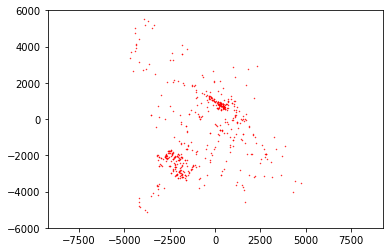

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.array([q.x for q in p])
y = np.array([q.y for q in p])
plt.scatter(x, y, s=0.2, c='r')

plt.axis("equal")
plt.ylim(-6000, 6000)

plt.show()

In [251]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


ppartP, lbx, lby = rangeAABB(p[123])

rt = []

for i in range(27):
    for j in range(27):
        rt.append(Rectangle((lbx+i*step, lby+j*step),10,10))

pc = PatchCollection(rt,facecolors='w', alpha=1,
                         edgecolor='k')

print(len(rt)) 


fig, ax = plt.subplots(1)
ax.add_collection(pc)


x = np.array([q.x for q in ppartP])
y = np.array([q.y for q in ppartP])
ax.scatter(x, y, s=1, c='r')
ax.axis("equal")

plt.show()

TypeError: rangeAABB() missing 1 required positional argument: 'rang'

In [344]:
import copy
import bisect
import uuid
from PIL import Image, ImageDraw

step = 10
num = 9
y_size = step*num   #90
x_size = y_size*3   #270

def rangeAABB(pt, rang):
    t = copy.deepcopy(pt)

    ox, oy = t.x, t.y
    t.x -= rang
    left = bisect.bisect_left(p, t)
    t.x += rang*2
    right = bisect.bisect_left(p, t)

    partP = p[left:right]

    ppartP = []
    for q in partP:
        if (q.y < oy+rang and q.y > oy-rang):
            ppartP.append(q)
    
    return ppartP, ox-rang, oy-rang



def drawAABB(ppartP, lbx, lby, size, path):
    global cntImgs
    global mapCSV
    f = Image.new('RGB', (size, size), (0, 0, 0))
    draw = ImageDraw.Draw(f)
    for pt in ppartP:
        xx = (pt.x - lbx)//step * step
        yy = size - ((pt.y - lby)//step + 1) * step

        # print(xx, yy)
        draw.rectangle((xx, yy, xx + step-1, yy + step-1), fill=colorDict[pt.type])

    arr = np.asarray(f)
    
    fname = uuid.uuid1()
    f.save('./data/{}/{}.jpg'.format(path, fname))
    mapCSV.append([cntImgs, fname])
    return arr

### 生成训练数据X

In [348]:
from time import time
cntImgs = 0
mapCSV = []
# data = np.zeros((1, x_size, x_size, 3))
size = x_size
pathname = 'X_270_270'

flag = True


lastTime = time()
for q in p:
    # if(cntImgs > 60):
    #     break
    cntImgs += 1
    ppartP, lbx, lby = rangeAABB(q, size/2)
    if(len(ppartP) == 1):
        continue
    
    arr = drawAABB(ppartP, lbx, lby, size, pathname)
    # if(flag): 
    #     data = arr[np.newaxis, :]
    #     flag = False
    # else:
    #     data = np.concatenate([data, arr[np.newaxis, :]])
    # print(arr.shape)
    # plt.imshow(arr)
    if(cntImgs % 500 == 0):
        print("Progress...{}/{}, {} seconds".format(cntImgs, len(p), time()-lastTime))
        lastTime = time()

# np.save('./data/{}.npy'.format(pathname), data)
print("Total Len", len(p))
print("Finish filter...Data size = ", data.shape[0])

import csv
with open('./data/{}.csv'.format(pathname), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['id', 'filename'])
    writer.writerows(mapCSV)


Progress...500/10414, 1.2130012512207031 seconds
Progress...1000/10414, 1.3150157928466797 seconds
Progress...2000/10414, 2.8369741439819336 seconds
Progress...2500/10414, 1.302008867263794 seconds
Progress...3000/10414, 1.2329814434051514 seconds
Progress...3500/10414, 1.2450175285339355 seconds
Progress...4000/10414, 1.2560310363769531 seconds
Progress...4500/10414, 1.2489464282989502 seconds
Progress...5000/10414, 1.5479998588562012 seconds
Progress...5500/10414, 1.3100697994232178 seconds
Progress...6000/10414, 1.3259289264678955 seconds
Progress...6500/10414, 1.6680278778076172 seconds
Progress...7000/10414, 1.4979727268218994 seconds
Progress...7500/10414, 1.4630000591278076 seconds
Progress...8000/10414, 1.3020014762878418 seconds
Progress...8500/10414, 1.2110035419464111 seconds
Progress...9000/10414, 1.144996166229248 seconds
Progress...9500/10414, 1.1889867782592773 seconds
Progress...10000/10414, 1.0160248279571533 seconds
Total Len 10414
Finish filter...Data size =  58


### 生成训练数据Y

In [349]:
index = []
with open('./data/X_270_270.csv','r') as csvfile:
    rows=csv.reader(csvfile)
    headers = next(rows)
    for row in rows:
        index.append(int(row[0])-1)

print(index)


7121, 7122, 7123, 7124, 7125, 7127, 7128, 7129, 7130, 7131, 7132, 7133, 7134, 7135, 7136, 7137, 7138, 7139, 7140, 7141, 7142, 7143, 7144, 7145, 7146, 7147, 7148, 7149, 7150, 7151, 7152, 7153, 7154, 7155, 7156, 7157, 7158, 7159, 7160, 7161, 7162, 7163, 7164, 7165, 7166, 7167, 7168, 7169, 7170, 7171, 7172, 7173, 7174, 7175, 7176, 7177, 7178, 7179, 7180, 7181, 7182, 7183, 7184, 7185, 7186, 7187, 7188, 7189, 7190, 7191, 7192, 7193, 7194, 7195, 7196, 7197, 7198, 7199, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7210, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256, 7257, 7258, 7259, 7260, 7261, 7262, 7263, 7264, 7265, 7266, 7267, 7268, 7269, 7270, 7271, 7272, 7273, 7274, 7275, 7276, 7277, 7278, 7279, 7280, 7281, 7282, 7283, 7284, 7285, 7286, 7287, 7288

In [350]:
from time import time
cntImgs = 0
mapCSV = []
# data = np.zeros((1, x_size, x_size, 3))
size = y_size
pathname = 'Y_90_90'

flag = True



lastTime = time()
for id in index:
    q = p[id]

    cntImgs = id+1
    ppartP, lbx, lby = rangeAABB(q, size/2)
    
    arr = drawAABB(ppartP, lbx, lby, size, pathname)
    # if(flag): 
    #     data = arr[np.newaxis, :]
    #     flag = False
    # else:
    #     data = np.concatenate([data, arr[np.newaxis, :]])
    # print(arr.shape)
    # plt.imshow(arr)
    if(cntImgs % 500 == 0):
        print("Progress...{}/{}, {} seconds".format(cntImgs, len(p), time()-lastTime))
        lastTime = time()

# np.save('./data/{}.npy'.format(pathname), data)
print("Total Len", len(p))
print("Finish filter...Data size = ", data.shape[0])

import csv
with open('./data/{}.csv'.format(pathname), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['id', 'filename'])
    writer.writerows(mapCSV)


Progress...500/10414, 0.4590473175048828 seconds
Progress...1000/10414, 0.47400450706481934 seconds
Progress...2000/10414, 0.9660048484802246 seconds
Progress...2500/10414, 0.48299479484558105 seconds
Progress...3000/10414, 0.6110177040100098 seconds
Progress...3500/10414, 0.7009842395782471 seconds
Progress...4000/10414, 0.7810149192810059 seconds
Progress...4500/10414, 0.6459875106811523 seconds
Progress...5000/10414, 0.6259939670562744 seconds
Progress...5500/10414, 0.550001859664917 seconds
Progress...6000/10414, 0.5940036773681641 seconds
Progress...6500/10414, 0.7209935188293457 seconds
Progress...7000/10414, 0.7040107250213623 seconds
Progress...7500/10414, 0.6499950885772705 seconds
Progress...8000/10414, 0.6579735279083252 seconds
Progress...8500/10414, 0.5190000534057617 seconds
Progress...9000/10414, 0.7340047359466553 seconds
Progress...9500/10414, 0.554995059967041 seconds
Progress...10000/10414, 0.7029867172241211 seconds
Total Len 10414
Finish filter...Data size =  58


In [359]:
filelist = []
pathname = 'Y_90_90'
with open('./data/{}.csv'.format(pathname),'r') as csvfile:
    rows=csv.reader(csvfile)
    headers = next(rows)
    for row in rows:
        filelist.append(row[1])

# print(filelist)
x = np.array([np.array(Image.open('./data/{}/'.format(pathname) + fname + '.jpg')) for fname in filelist])
print(x.shape)
np.save('./data/{}.npy'.format(pathname), x)

(10342, 90, 90, 3)


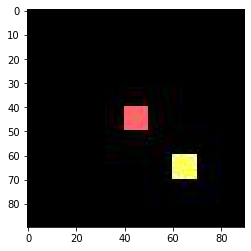

In [361]:
b = np.load('./data/{}.npy'.format(pathname))
plt.imshow(b[0, :])

In [ ]:
d = np.load('./data/{}.npy'.format('X_270_270'))
plt.show(d[0, :])

Error: Error: Activating Python 3.7.5 64-bit ('amo': conda) to run Jupyter failed with Error: StdErr from ShellExec, The process cannot access the file because it is being used by another process.
The process cannot access the file because it is being used by another process.
The system cannot find the file C:\Users\amomorning\AppData\Local\Temp\conda-5423-26706.tmp.
The process cannot access the file because it is being used by another process.
.